In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as visionmodels
import torchvision.transforms as transforms
import torch.utils.data.dataloader as DataLoader
import torch.utils.data.dataset as Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable,grad
from torchvision import datasets
from collections import *
import os
from torchvision.io import read_image
from datetime import datetime
import glob
from zipfile import ZipFile
from google.colab import drive
drive.mount('/content/gdrive')

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

Mounted at /content/gdrive


# Feature Extraction Network

In [5]:
#StyleOutput = namedtuple("StyleOutput", ["relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1"]) 
#FeatureOutput = namedtuple("FeatureOutput", ["relu4_2"]) 
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

class FeatureExtractionNetwork(nn.Module): 
  def __init__(self, vgg_network): 
    super().__init__() 
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    self.norm = Normalization(cnn_normalization_mean,cnn_normalization_std)
    features = list(vgg_network.features)
    self.features = nn.ModuleList(features).eval() 
    self.features_name_mapping = [32,45]
    self.styles_name_mapping = [2,9,26,23,30,42]

  def forward(self, x,mode = 'style'): 
    x  = self.norm(x)
    style_output = []
    feature_output = []
    for i,feature in enumerate(self.features): 
      x = feature(x) 
      if (mode ==  'style') and (i in self.styles_name_mapping): 
        style_output.append(x) 
      if (mode == 'content') and (i in self.features_name_mapping): 
        feature_output.append(x) 
      if (mode == 'both'): 
        if i in self.styles_name_mapping: 
          style_output.append(x) 
        if i in self.features_name_mapping: 
          feature_output.append(x) 
    if mode == 'style': 
      return style_output
    elif mode == 'content': 
      return feature_output
    elif mode == 'both': 
      return style_output, feature_output


#Loss Networks

In [6]:
class StyleLoss(nn.Module): 
  def __init__(self): 
    super().__init__()
    self.loss = nn.MSELoss(reduction = 'sum')

  def forward(self, F_target, F_source): #assume given a list of feature maps F, corresponding to same map outputs
    l = len(F_target) #number of feature layers we are sampling from 
    w_l = 1/l
    style_loss = 0
    for f_target,f_source in zip(F_target, F_source): 
      n,c,h,w = f_target.shape
      weight = 1/(c*h*w)**2
      style_loss += w_l*weight*self.loss(self.gram_matrix(f_target[0]),self.gram_matrix(f_source[1]).detach())
    return style_loss


  '''
    need to compute the gram matrices for computing the loss
    N x C x H x w ----> N x C x C 
  '''
  def gram_matrix(self,A): 
    C, _, _ = A.shape
    A = A.view(C,-1)
    G = torch.mm(A,A.t())
    return G #returns CxC gram matrix

class FeatureLoss(nn.Module): 
  def __init__(self): 
    super().__init__() 
    self.loss = nn.MSELoss(reduction = 'sum') 

  def forward(self,F_target, F_source):  #feature maps to compare
    feature_loss = 0 
    for f_target, f_source in zip(F_target, F_source): 
      feature_loss += self.loss(f_target[0], f_source[0].detach()) 
    return feature_loss

#Training Loop

In [30]:
def normMSELoss(input,target): 
  n, c, h, w = input.shape
  return (1/(n*c*h*w))*torch.linalg.norm(input.view(n,c,-1)-target.view(n,c,-1),2,2).sum()
###computes Normalized Euclidean content loss betweens a set of content maps CONTENTS and TARGET_CONTENTS
def contentLoss(contents, target_content): 
  content_loss = 0 
  for content,target in zip(contents, target_content): 
    content_loss+= normMSELoss(content,target) 
  return content_loss
###PIXELWISELOSS normalized loss
def pixelLoss(gen_image, target_image): 
  assert gen_image.shape == target_image.shape
  n,c,h,w = gen_image.shape
  return (1/(n*c*h*w))*torch.linalg.norm(gen_image.view(n,c,-1)-target_image.view(n,c,-1),2,2).sum()
###computes gram matrix
def gram_matrix(A): 
  N,C, h, w = A.shape
  if N == 1:
    A = A.view(C,-1)
    G = torch.mm(A,A.t())
  else: 
    A = A.view(N,C,-1)
    G = torch.bmm(A,A.transpose(1,2))
  return G.div(C*h*w) #returns CxC normalized gram matrix
#computs gram matrix loss based on euclidean distance
def gramMSELoss(input,target): 
  G = gram_matrix(input)
  return F.mse_loss(G,target) 
#compute Frobenius based loss
def gramFrobLoss(input,target): 
  G = gram_matrix(input) 
  return torch.linalg.norm(G-target,'fro',(1,2)).sum()
###computes styleLosses between set of style representations of the target and source
###can specify the mode between frobenius and 2-norm based
def styleLoss(styles,target_styles,mode :str = 'fro'): 
  style_loss = 0 
  for style,target in zip(styles,target_styles): 
    if mode == 'fro': 
      style_loss += gramFrobLoss(style,target) 
    elif mode == 'mse': 
      style_loss += gramMSELoss(style,target) 
  return style_loss


def train(feature_extraction_network,       #network for extracting features
          feature_loss_network,             #network for computing feature losses
          style_loss_network,               #network for computing style losses 
          content_image,                    #content target image
          style_image,                      #style target image
          lmbda: float = 1e3,              #balance terms (a/b) from paper
          num_epochs: int = 2000, 
          lr:float = 1e-2
          ): 
  # input = torch.cat((content_image, style_image),dim = 0)
  # input = Variable(input).to(device)
  style_input = Variable(style_image).to(device)
  content_input = Variable(content_image).to(device)
  z = content_image.clone().detach()
  z = Variable(z).to(device)
  z.requires_grad_(True)
  optimizer = optim.Adam([z],lr = lr)
  for p in feature_extraction_network.parameters(): 
    p.requires_grad = False
  style_features, _ = feature_extraction_network(style_input,mode = 'both')
  for i,s in enumerate(style_features): 
    style_features[i] = gram_matrix(s).unsqueeze(0).to(device)
  _ ,content_features = feature_extraction_network(content_input,mode = 'both')
  for epoch in range(num_epochs): 
    
    
    #content_features = feature_extraction_network(content,mode = 'content') 
    #style_features = feature_extraction_network(style, mode = 'style') 
    def closure():
      optimizer.zero_grad()
      z_style,z_content = feature_extraction_network(z,mode = 'both') 
      style_loss = styleLoss(z_style, style_features)
      content_loss = contentLoss(z_content, content_features)
      loss = style_loss*lmbda + content_loss
      loss.backward()

      if (epoch+1)%100 == 0: 
        print('__________________________\nCurrent Losses at epoch {}/{}: {}, {}'.format(epoch, num_epochs, style_loss.detach(), content_loss.detach()))
      return loss
    optimizer.step(closure)
  return z.detach().clamp_(0,1)
  



#Main Code

gdrive/  sample_data/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


__________________________
Current Losses at epoch 99/500: 0.017082108184695244, 0.003895839210599661
__________________________
Current Losses at epoch 199/500: 0.01942942850291729, 0.004019323270767927
__________________________
Current Losses at epoch 299/500: 0.017402805387973785, 0.004042747430503368
__________________________
Current Losses at epoch 399/500: 0.022160261869430542, 0.0039266180247068405
__________________________
Current Losses at epoch 499/500: 0.015102733857929707, 0.00402485765516758


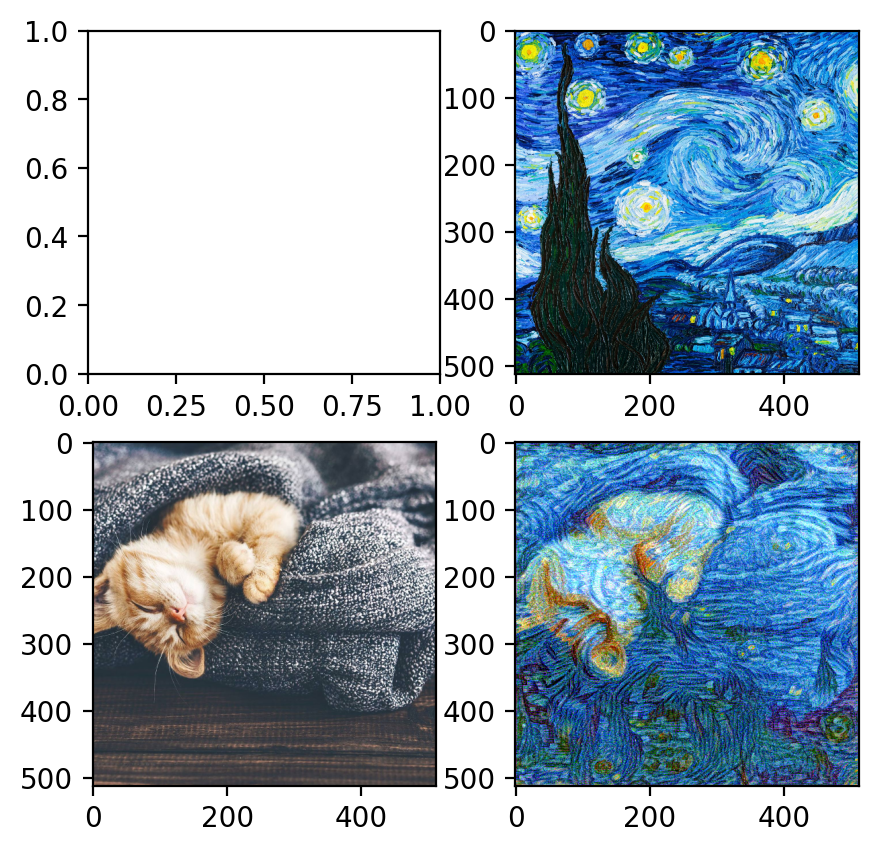

In [31]:
if __name__ == '__main__': 
  os.chdir('/content/')
  %ls 
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  vgg_net = visionmodels.vgg19_bn(pretrained=True).to(device)
  vgg_net.eval()
  feature_net = FeatureExtractionNetwork(vgg_net).to(device) 
  style_loss = StyleLoss().to(device)
  content_loss = FeatureLoss().to(device) 

  im_height = 512
  im_width = 512
  im_channels = 3
  transform = transforms.Compose([ transforms.Resize(max(im_width,im_height)), transforms.CenterCrop((im_height,im_width))])
  monet_transform = transforms.Compose([transforms.Resize(max(im_width,im_height)),transforms.CenterCrop((im_height,im_width))])

  content_image_path = '/content/gdrive/MyDrive/Colab Notebooks/Style Transfer/data/cats/cat1.jpg' 
  #content_image_path = '/content/gdrive/MyDrive/Colab Notebooks/Style Transfer/data/cats/3683 - Copy (2).jpg' 
  style_image_path = '/content/gdrive/MyDrive/Colab Notebooks/Style Transfer/data/monet/The-Starry-Night.jpg' 
  content_image = transform(read_image(content_image_path)/255).unsqueeze(0)
  style_image = transform(read_image(style_image_path)/255).unsqueeze(0)
  content_image = content_image.view(1,im_channels,im_height,im_width)
  style_image = style_image.view(1,im_channels,im_height,im_width)
    

  output = train(feature_net,       #network for extracting features
          content_loss,             #network for computing feature losses
          style_loss,               #network for computing style losses 
          content_image,                    #content target image
          style_image,                      #style target image
          lmbda = 1e3,              #balance terms (a/b) from paper
          num_epochs=500,
          lr = .1
          )
  
  fig = plt.figure(figsize = (5,5), dpi = 200) 
  ax = fig.subplots(2,2)
  ax[1,1].imshow(output[0].detach().cpu().permute(1,2,0)) 
  ax[1,0].imshow(content_image[0].detach().cpu().permute(1,2,0))
  ax[0,1].imshow(style_image[0].detach().cpu().permute(1,2,0))
  plt.show(block = False)